In [2]:
import numpy as np 
import pandas as pd 

import pyspark
from pyspark import SparkContext
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pyspark.sql.functions as func


sc = SparkContext("local","Ritesh")
sqlContext = pyspark.SQLContext(sc)
sc.version

'2.4.4'

In [3]:
from pyspark.sql.types import *
#Defining own schema
#This is done so that there would not be any conflict between datatypes
data_schema = [StructField('id', IntegerType(), True), 
               StructField('name', StringType(), True),
               StructField('host_id', IntegerType(), True),
               StructField('host_name', StringType(), True),
               StructField('neighbourhood_group', StringType(), True),
               StructField('neighbourhood', StringType(), True),
               StructField('latitude', FloatType(), True),
               StructField('longitude', FloatType(), True),
               StructField('room_type', StringType(), True),
               StructField('price', IntegerType(), True),
               StructField('minimum_nights', IntegerType(), True),
               StructField('number_of_reviews', IntegerType(), True),
               StructField('last_review', DateType(), True),
               StructField('reviews_per_month', FloatType(), True),
               StructField('calculated_host_listings_count', IntegerType(), True),
               StructField('availability_365', IntegerType(), True),
              ]

In [5]:
final_struc = StructType(data_schema)

df = sqlContext.read.csv('Airbnb_NYC.csv', header = True,schema = final_struc,mode="DROPMALFORMED")

In [6]:
df_neigh_gr_pd = df.groupBy("neighbourhood_group").agg(func.mean("price").alias("mean_price")).orderBy('mean_price', ascending=False).toPandas().head(10)
df_neigh_gr_pd

,neighbourhood_group,mean_price
0,Manhattan,196.743216
1,Brooklyn,124.398404
2,Staten Island,114.994595
3,Queens,99.576909
4,Bronx,87.728704
5,Greenwich Village,55.500000
6,Jackson Heights,16.000000
7,Clinton Hill,14.000000
8,Brooklyn Heights,14.000000
9,Upper West Side,13.000000


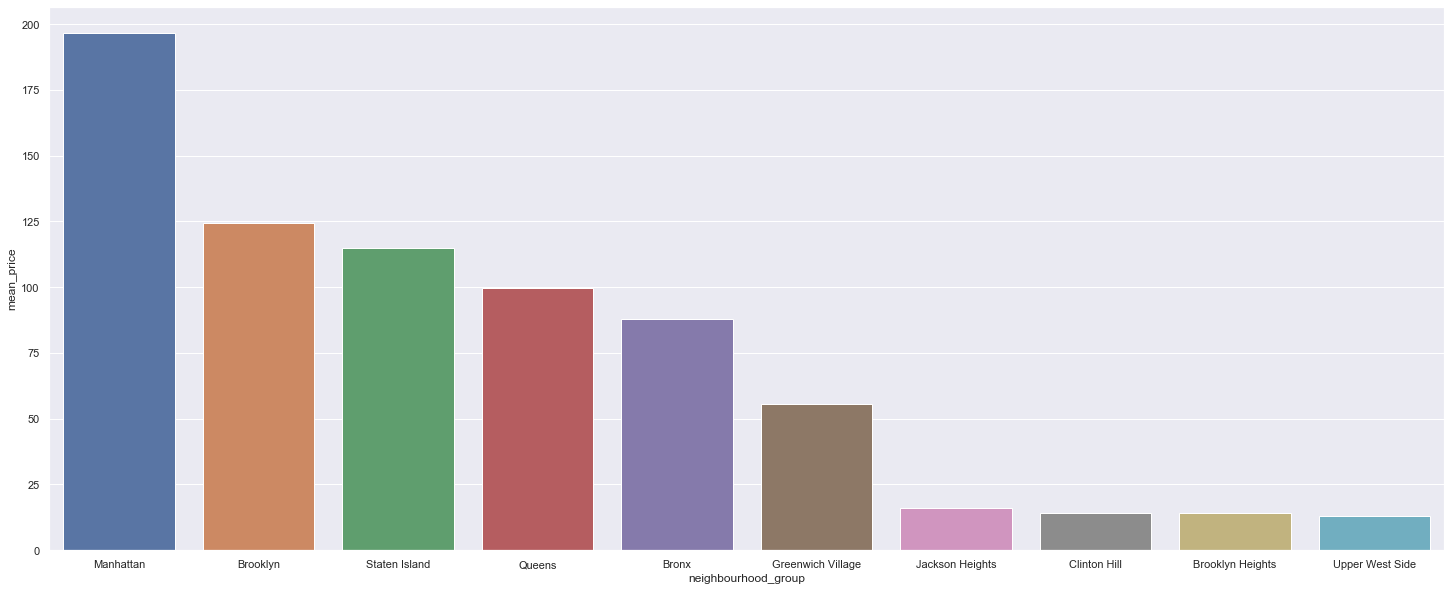

In [7]:
plt.figure(figsize=(25, 10))
sns.barplot(x="neighbourhood_group", y="mean_price", data=df_neigh_gr_pd)

In [8]:
#This will calculate mean price of each distinct neighbourhood
df_neigh_pd = df.groupBy('neighbourhood').agg(func.mean("price").alias("mean_price")).orderBy('mean_price', ascending=True).toPandas().head(20)
df_neigh_pd

,neighbourhood,mean_price
0,None,NaN
1,40.83166,1.0
2,40.7578,1.0
3,40.80958,1.0
4,40.76805,1.0
5,40.64936,1.0
6,40.83117,1.0
7,40.73018,1.0
8,40.73543,1.0
9,40.75777,1.0


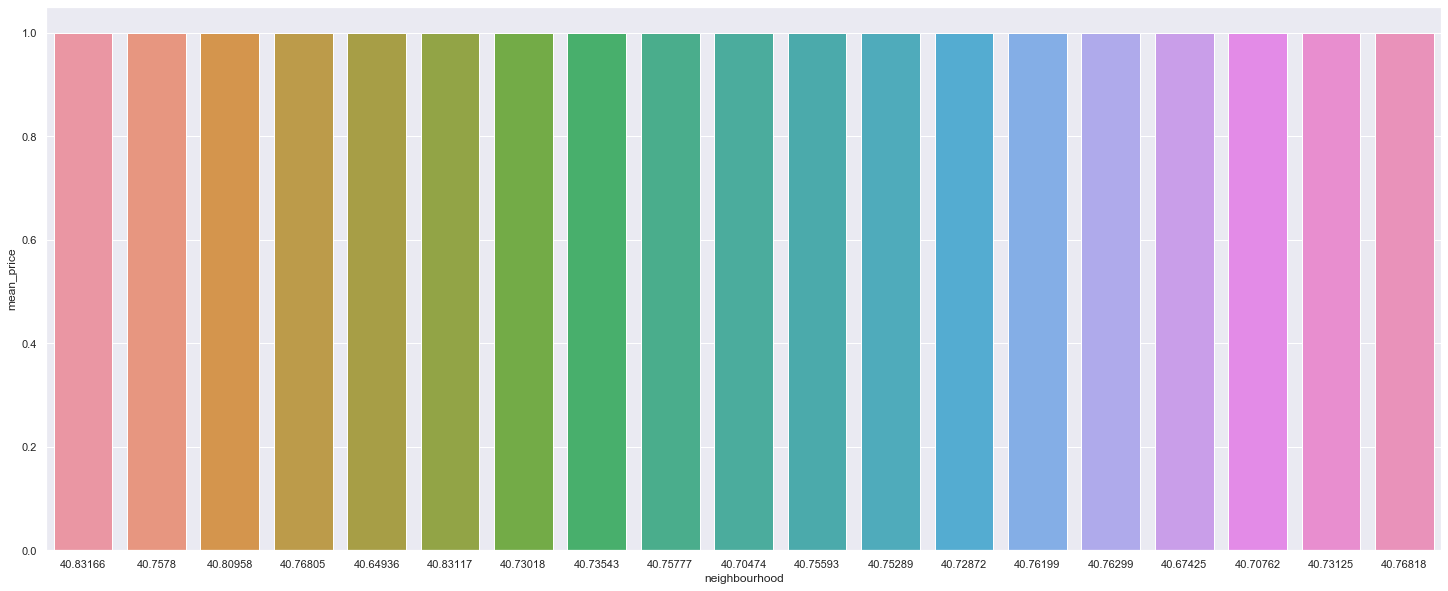

In [9]:
plt.figure(figsize=(25, 10))
sns.barplot(x="neighbourhood", y="mean_price", data=df_neigh_pd)

In [10]:
#calculaitng sum of reviews for each host_id
df_host_popularity = df.groupby('host_id').agg(func.sum('number_of_reviews').alias('sum_review'))
#calculating total reviews for complete data
total_reviews = df.select(func.sum('number_of_reviews')).head()[0]
total_reviews

1133522

In [11]:
#import udf
from pyspark.sql import udf
import pyspark.sql.functions as F

In [12]:
#Defining function for withcolumn operation and then udf
def func_divide(a1,a2):
    return a1*100.0/float(a2)

In [13]:
divide_func_sp = F.udf(func_divide,FloatType())
divide_func_sp

<function __main__.func_divide(a1, a2)>

In [14]:
df_host_popularity = df_host_popularity.withColumn('total_sum_reviews', F.lit(total_reviews))
df_host_popularity.show()

+--------+----------+-----------------+
| host_id|sum_review|total_sum_reviews|
+--------+----------+-----------------+
|  291112|        35|          1133522|
| 1384111|       103|          1133522|
| 1597481|        13|          1133522|
| 2108853|        18|          1133522|
| 2429432|        27|          1133522|
| 2530670|       134|          1133522|
| 3432742|         2|          1133522|
| 1360296|        13|          1133522|
| 2124690|         1|          1133522|
| 6414252|         1|          1133522|
| 9637768|        47|          1133522|
| 9947836|        87|          1133522|
| 9430366|       159|          1133522|
| 7974574|         5|          1133522|
| 5907325|        32|          1133522|
|13749425|       198|          1133522|
| 5771331|        20|          1133522|
| 9784206|       204|          1133522|
| 4702135|         0|          1133522|
|19239110|        25|          1133522|
+--------+----------+-----------------+
only showing top 20 rows



In [17]:
df_host_popularity = df_host_popularity.withColumn('popularity_index',divide_func_sp('sum_review','total_sum_reviews'))
df_host_popularity.orderBy('popularity_index', ascending=False).show(1)

Py4JJavaError: An error occurred while calling o245.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 42 in stage 19.0 failed 1 times, most recent failure: Lost task 42.0 in stage 19.0 (TID 1173, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-12-f2877fdd75e9>", line 3, in func_divide
TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:30)
	at org.spark_project.guava.collect.Ordering.leastOf(Ordering.java:670)
	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1433)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1430)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1035)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1017)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1.apply(RDD.scala:1439)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1426)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:136)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-12-f2877fdd75e9>", line 3, in func_divide
TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:30)
	at org.spark_project.guava.collect.Ordering.leastOf(Ordering.java:670)
	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1433)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1430)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [18]:
df_host_popularity = df_host_popularity.select('host_id','popularity_index')
df_host_popularity.show()

+--------+----------------+
| host_id|popularity_index|
+--------+----------------+
|  291112|    0.0030877213|
| 1384111|    0.0090867225|
| 1597481|    0.0011468679|
| 2108853|     0.001587971|
| 2429432|    0.0023819564|
| 2530670|    0.0118215615|
| 3432742|    1.7644122E-4|
| 1360296|    0.0011468679|
| 2124690|     8.822061E-5|
| 6414252|     8.822061E-5|
| 9637768|    0.0041463687|
| 9947836|     0.007675193|
| 9430366|     0.014027077|
| 7974574|    4.4110304E-4|
| 5907325|    0.0028230594|
|13749425|      0.01746768|
| 5771331|    0.0017644122|
| 9784206|     0.017997004|
| 4702135|             0.0|
|19239110|    0.0022055153|
+--------+----------------+
only showing top 20 rows



In [19]:
df_host_popularity.orderBy('popularity_index', ascending=False).show(10)

Py4JJavaError: An error occurred while calling o308.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 42 in stage 23.0 failed 1 times, most recent failure: Lost task 42.0 in stage 23.0 (TID 1220, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-12-f2877fdd75e9>", line 3, in func_divide
TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:30)
	at org.spark_project.guava.collect.Ordering.leastOf(Ordering.java:670)
	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1433)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1430)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1035)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1017)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1.apply(RDD.scala:1439)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1426)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:136)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-12-f2877fdd75e9>", line 3, in func_divide
TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:30)
	at org.spark_project.guava.collect.Ordering.leastOf(Ordering.java:670)
	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1433)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1430)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [20]:
#merging the popularity_index to the main dataframe
df = df.join(df_host_popularity, "host_id", "left")
df.show(2)

+-------+----+--------------------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+
|host_id|  id|                name|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|
+-------+----+--------------------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+
|   2787|2539|Clean & quiet apt...|     John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|     0.009263163|
|   

In [21]:
#spark filter and sorting
df.filter(df['minimum_nights'] > 10).orderBy('popularity_index', ascending=False).select(df['neighbourhood']).show(20)

+------------------+
|     neighbourhood|
+------------------+
|       Murray Hill|
|   Upper East Side|
|       Murray Hill|
|Financial District|
|       Murray Hill|
|Financial District|
|       Murray Hill|
|    Hell's Kitchen|
|       Murray Hill|
|Financial District|
|       Murray Hill|
|       Murray Hill|
|           Midtown|
|       Murray Hill|
|  Theater District|
|       Murray Hill|
|           Chelsea|
|       Murray Hill|
|  Theater District|
|  Theater District|
+------------------+
only showing top 20 rows



In [22]:
df_popular_regions = df.groupby('neighbourhood').agg(func.sum('popularity_index').alias('pop_reg'))
df_popular_regions.show()

+------------------+--------------------+
|     neighbourhood|             pop_reg|
+------------------+--------------------+
|            Corona|  0.3798779395292513|
|      Richmondtown|0.006969428155571222|
|      Prince's Bay|0.002029074006713927|
|       Westerleigh|0.001587970909895...|
|        Mill Basin|0.006087222136557102|
|      Civic Center| 0.09210231501492672|
|        Douglaston|0.021966931177303195|
|        Mount Hope| 0.06351883811294101|
|       Marble Hill|  0.0169383569736965|
|         Rego Park|   0.402727072883863|
|     Dyker Heights| 0.07419353185105138|
| Kew Gardens Hills| 0.03793486161157489|
|      Dongan Hills| 0.01817344536539167|
|Financial District|   26.01537540461868|
|       Bay Terrace| 0.02302557899383828|
|           Midtown|   6.244784004520625|
|   Jackson Heights|  1.0536187172110658|
|           Bayside|  0.1852632757218089|
|    Hell's Kitchen|  15.650335770944366|
|        Highbridge|  0.3594107596145477|
+------------------+--------------

In [23]:
df_popular_regions = df_popular_regions.orderBy('pop_reg', ascending=False).toPandas().head(10)
df_popular_regions.head()

,neighbourhood,pop_reg
0,Financial District,26.015375
1,Bedford-Stuyvesant,23.880260
2,Hell's Kitchen,15.650336
3,Harlem,12.463102
4,Williamsburg,12.265223


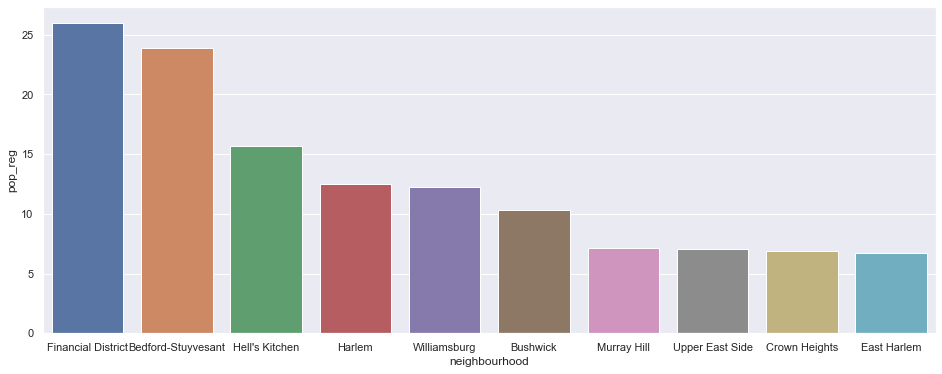

In [24]:
plt.figure(figsize=(16, 6))
sns.barplot(x='neighbourhood', y='pop_reg', data=df_popular_regions)

In [27]:
# Calculating host_id’s popularity in its neighbourhood
# Creating a column host_neighbourhood_popularity by calculating relative percentage of reviews of host among total reviews in that region.
#Summing no. of reviews for each neighbourhood
df_neighbourhood_sum = df.groupby('neighbourhood').agg(func.sum('number_of_reviews').alias('sum_reviews_ne'))

In [28]:
df_neighbourhood_sum.show(5)

+-------------+--------------+
|neighbourhood|sum_reviews_ne|
+-------------+--------------+
|       Corona|          1806|
| Richmondtown|            79|
| Prince's Bay|            23|
|  Westerleigh|            18|
|   Mill Basin|            69|
+-------------+--------------+
only showing top 5 rows



In [29]:
df_neighbourhood_host_sum = df.groupby('host_id','neighbourhood').agg(func.sum('number_of_reviews').alias('sum_reviews_id_ne'))
df_neighbourhood_host_sum.show()

+--------+--------------------+-----------------+
| host_id|       neighbourhood|sum_reviews_id_ne|
+--------+--------------------+-----------------+
|  829652|            Gramercy|              105|
| 1269455|        West Village|               37|
| 1498424|         Fort Greene|               35|
| 1633100|            Bushwick|               42|
|  160565|  Bedford-Stuyvesant|                3|
| 4241953|            Flushing|               81|
| 3898812|             Astoria|               58|
| 6873370|         Sunset Park|               24|
|  173980|  Bedford-Stuyvesant|              181|
| 1472225|        East Village|               59|
|11192207|     Upper West Side|                2|
|10930874|        Forest Hills|                1|
|16288928|          Park Slope|              136|
| 9604972|     Lower East Side|                1|
|17604079|              Harlem|                1|
|17773625|             Tribeca|               73|
| 2119276|     Upper East Side|               20|


In [30]:
#merging column
df_neighbourhood_host_merged = df_neighbourhood_host_sum.join(df_neighbourhood_sum,'neighbourhood','left')
df_neighbourhood_host_merged.filter(df['neighbourhood'] == 'Williamsburg').orderBy('host_id', ascending=True).show(10)

+-------------+-------+-----------------+--------------+
|neighbourhood|host_id|sum_reviews_id_ne|sum_reviews_ne|
+-------------+-------+-----------------+--------------+
| Williamsburg|   2438|                1|         85368|
| Williamsburg|  10889|              383|         85368|
| Williamsburg|  15991|              148|         85368|
| Williamsburg|  19402|               37|         85368|
| Williamsburg|  21207|                9|         85368|
| Williamsburg|  21306|                2|         85368|
| Williamsburg|  39304|                0|         85368|
| Williamsburg|  45384|               20|         85368|
| Williamsburg|  51414|                9|         85368|
| Williamsburg|  52043|               53|         85368|
+-------------+-------+-----------------+--------------+
only showing top 10 rows



In [31]:
def func_divide(a1,a2):
    if(a2!=0):
        ans = a1*100.0/float(a2)
    else:
        ans = 0
    return ans

In [32]:
divide_func_sp = F.udf(func_divide,FloatType())
df_neighbourhood_host_merged = df_neighbourhood_host_merged.withColumn('host_neighbourhood_popularity',divide_func_sp('sum_reviews_id_ne','sum_reviews_ne'))
df_neighbourhood_host_merged.show()

+-------------+---------+-----------------+--------------+-----------------------------+
|neighbourhood|  host_id|sum_reviews_id_ne|sum_reviews_ne|host_neighbourhood_popularity|
+-------------+---------+-----------------+--------------+-----------------------------+
|       Corona|265288059|                7|          1806|                    0.3875969|
|       Corona|176679165|              156|          1806|                     8.637874|
|       Corona| 32446721|              100|          1806|                    5.5370984|
|       Corona|124042625|                4|          1806|                   0.22148395|
|       Corona| 44620317|              114|          1806|                    6.3122926|
|       Corona| 34129674|                0|          1806|                          0.0|
|       Corona|  5261297|               45|          1806|                    2.4916945|
|       Corona| 98697139|               43|          1806|                    2.3809524|
|       Corona| 31307

In [34]:
df_neighbourhood_host_merged.orderBy('host_neighbourhood_popularity', ascending=False).show(20)

Py4JJavaError: An error occurred while calling o502.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 42 in stage 82.0 failed 1 times, most recent failure: Lost task 42.0 in stage 82.0 (TID 5075, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-31-937e85ddc4ff>", line 3, in func_divide
TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage11.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:30)
	at org.spark_project.guava.collect.Ordering.leastOf(Ordering.java:628)
	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1433)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1430)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1035)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1017)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1.apply(RDD.scala:1439)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1426)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:136)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Rit\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-31-937e85ddc4ff>", line 3, in func_divide
TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage11.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:30)
	at org.spark_project.guava.collect.Ordering.leastOf(Ordering.java:628)
	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1433)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1$$anonfun$30.apply(RDD.scala:1430)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [35]:
df_neighbourhood_host_merged = df_neighbourhood_host_merged.select('host_id','neighbourhood','host_neighbourhood_popularity')
df_neighbourhood_host_merged.show(5)

+---------+-------------+-----------------------------+
|  host_id|neighbourhood|host_neighbourhood_popularity|
+---------+-------------+-----------------------------+
|265288059|       Corona|                    0.3875969|
|176679165|       Corona|                     8.637874|
| 32446721|       Corona|                    5.5370984|
|124042625|       Corona|                   0.22148395|
| 44620317|       Corona|                    6.3122926|
+---------+-------------+-----------------------------+
only showing top 5 rows



In [36]:
#To validate results, for baychester the sum of all the host_neighbourhood_popularity = 100.0
df_neighbourhood_host_merged.filter(df_neighbourhood_host_merged['neighbourhood']=='Baychester').show()

+---------+-------------+-----------------------------+
|  host_id|neighbourhood|host_neighbourhood_popularity|
+---------+-------------+-----------------------------+
|209306758|   Baychester|                     6.774194|
| 64425305|   Baychester|                    0.9677419|
|246653349|   Baychester|                     3.548387|
|129890157|   Baychester|                          0.0|
| 57165692|   Baychester|                     88.70968|
+---------+-------------+-----------------------------+



In [37]:
df = df.join(df_neighbourhood_host_merged,['host_id','neighbourhood'],'left')
df.filter(df['host_neighbourhood_popularity']>90).show(2)

+--------+-------------+--------+--------------------+---------+-------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+
| host_id|neighbourhood|      id|                name|host_name|neighbourhood_group|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|host_neighbourhood_popularity|
+--------+-------------+--------+--------------------+---------+-------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+
| 6402171|    Rossville|26258351|Escape NYC in the...|    Taryn|      Staten Island| 40.5479|-74.21017|Entire home/apt|   75|             3|        

In [38]:
# Finding:
# Maximum revenue in Private Rooms
# Minimum revenue in Private Rooms
# Maximum revenue in Entire Homes
# Minimum revenue in Entire Homes
#Filtering only private room and entire room

In [39]:
df_neighbourhood_room_type = df.filter(df['room_type'] != 'Shared room')
df_neighbourhood_room_type = df_neighbourhood_room_type.groupby('neighbourhood','room_type').agg(func.sum('price').alias('price_sum'))
df_neighbourhood_room_type.show()

+-----------------+---------------+---------+
|    neighbourhood|      room_type|price_sum|
+-----------------+---------------+---------+
|Battery Park City|Entire home/apt|    23450|
|   Morris Heights|Entire home/apt|      421|
|     Coney Island|   Private room|      480|
|Battery Park City|   Private room|     2224|
|        Unionport|   Private room|      225|
|   Williamsbridge|Entire home/apt|     2818|
|          Arverne|   Private room|     2369|
|       Morrisania|   Private room|      623|
|       Kensington|   Private room|     5819|
|    Schuylerville|   Private room|      624|
|             NoHo|Entire home/apt|    21474|
|      Murray Hill|   Private room|    10335|
|        Laurelton|   Private room|      552|
|         Glendale|Entire home/apt|     3420|
|      Boerum Hill|Entire home/apt|    27624|
|       Ozone Park|Entire home/apt|     3649|
|     Williamsburg|   Private room|   170841|
|  Upper West Side|Entire home/apt|   328724|
|  East Morrisania|   Private room

In [40]:
#pivot operation 
df_neighbourhood_room_type = df_neighbourhood_room_type.groupby('neighbourhood').pivot('room_type').sum('price_sum')
df_neighbourhood_room_type.show()

+------------------+---------------+------------+
|     neighbourhood|Entire home/apt|Private room|
+------------------+---------------+------------+
|            Corona|           1549|        1485|
|      Prince's Bay|           1520|         118|
|      Richmondtown|             78|        null|
|        Mill Basin|            719|        null|
|       Westerleigh|            103|          40|
|      Civic Center|           7925|        2056|
|        Douglaston|            402|         215|
|        Mount Hope|           1079|         471|
|       Marble Hill|            459|         611|
|         Rego Park|           5085|        3486|
|     Dyker Heights|            804|         278|
| Kew Gardens Hills|           2052|         868|
|      Dongan Hills|            405|         151|
|       Bay Terrace|            631|         189|
|Financial District|         138853|       26831|
|           Bayside|           4616|        1544|
|   Jackson Heights|           7232|        7137|


In [41]:
#Maximum revenue in Private Rooms
df_neighbourhood_room_type.orderBy('Private room', ascending=False).show(1)

df_min = df_neighbourhood_room_type.orderBy('Private room', ascending=True)
#Minimum revenue in Private Rooms after filetering out null values
df_min[df_min['Private room'].isNotNull()].show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Williamsburg|         389426|      170841|
+-------------+---------------+------------+
only showing top 1 row

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Graniteville|            186|          20|
+-------------+---------------+------------+
only showing top 1 row



In [42]:
##minimum revenue in Entire home/apt Rooms
df_neighbourhood_room_type.orderBy('Entire home/apt', ascending=True).filter(df_neighbourhood_room_type['Entire home/apt'].isNotNull()).show(1)

###maximum revenue in Entire home/apt Rooms

df_neighbourhood_room_type.orderBy('Entire home/apt', ascending=False).show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
|     New Dorp|             57|        null|
+-------------+---------------+------------+
only showing top 1 row

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Williamsburg|         389426|      170841|
+-------------+---------------+------------+
only showing top 1 row



In [43]:
# Calculating the average price income for private rooms and entire homes for each of the neighbourhoods

df_neighbourhood_room_type_mean = df.filter(df['room_type'] != 'Shared room')
df_neighbourhood_room_type_mean = df_neighbourhood_room_type_mean.groupby('neighbourhood','room_type').agg(func.mean('price').alias('average_region_price'))
df_neighbourhood_room_type_mean_pivot = df_neighbourhood_room_type_mean.groupby('neighbourhood').pivot('room_type').sum('average_region_price')
df_neighbourhood_room_type_mean_pivot.show()

+------------------+------------------+------------------+
|     neighbourhood|   Entire home/apt|      Private room|
+------------------+------------------+------------------+
|            Corona|119.15384615384616|              55.0|
|      Prince's Bay| 506.6666666666667|             118.0|
|      Richmondtown|              78.0|              null|
|        Mill Basin|            179.75|              null|
|       Westerleigh|             103.0|              40.0|
|      Civic Center|226.42857142857142|120.94117647058823|
|        Douglaston|             134.0|             53.75|
|        Mount Hope|             107.9|              47.1|
|       Marble Hill|              91.8| 87.28571428571429|
|         Rego Park|           127.125| 59.08474576271186|
|     Dyker Heights|114.85714285714286|              69.5|
| Kew Gardens Hills|120.70588235294117| 96.44444444444444|
|      Dongan Hills|            101.25|50.333333333333336|
|       Bay Terrace|210.33333333333334|              94.

<Figure size 2160x720 with 0 Axes>

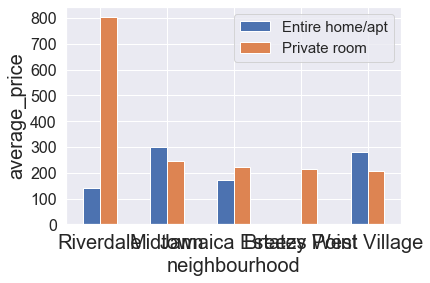

In [44]:
df_neighbourhood_room_type_mean_pivot = df_neighbourhood_room_type_mean_pivot.toPandas()
#Plotting 
plt.figure(figsize=(30, 10))
labels = []

ax=df_neighbourhood_room_type_mean_pivot.sort_values('Private room', ascending=False).head().plot(kind='bar', width = 0.5)
ax.set_xlabel('neighbourhood', fontsize = 20)
ax.set_ylabel('average_price', fontsize = 20)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
a = [item.get_text() for item in ax.get_xticklabels()]  #to get labels as they are coming as index
for i in a:
    labels.append(df_neighbourhood_room_type_mean_pivot['neighbourhood'][int(i)])
ax.set_xticklabels(labels)  #setting xticks as neighbourhood name
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation('horizontal')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)     
plt.rcParams["figure.figsize"] = fig_size
plt.legend(prop={'size':'15'})
plt.show(ax)

In [45]:
# Creating a column depicting relative price difference of that host with respect to the neighbourhood’s average pricing.

df = df.join(df_neighbourhood_room_type_mean,['neighbourhood','room_type'],'left')
df.filter(df['neighbourhood'] == 'Kensington').show()

+-------------+------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+
|neighbourhood|   room_type|  host_id|      id|                name|host_name|neighbourhood_group|latitude|longitude|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|host_neighbourhood_popularity|average_region_price|
+-------------+------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+
|   Kensington|Private room|  6755111| 1239293|Cozy Retreat in B...|  Jessica|           Br

In [ ]:
#Filtering out null values for price
temp1 = df.filter(df['price'].isNotNull())
#Filtering out null values for average_region_price
temp1 = temp1.filter(temp1['average_region_price'].isNotNull())
#Defining function and converting it to udf function for with column operation
def func_divide1(a1,a2):
    if(type(a1)=='NoneType' or type(a2)=='NoneType'):
        ans = 0
    elif(a1!=0):
        ans = ((a1-a2)*100.0)/float(a1)
    else:
        ans = 0
    return ans

divide_func_sp1 = F.udf(func_divide1,FloatType())
#withcolumn operation
df = temp1.withColumn('region_price_margin',divide_func_sp1('price','average_region_price'))
df.show(1)